This notebook created the visualizations that are used in figure 3 to illustrate how collisions are resolved

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import division
import six, sys
sys.path.append('..'); import pathcustomize, about
about.about()

import random
import itertools

import pandas as pd
import numpy as np


from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.image as mpimg
import networkx as nx
#from IPython.core.display import Image as display_image

#os.environ.setdefault('MULTIWORM_SETTINGS', 'multiworm_settings')

import waldo.wio as wio
import multiworm
from waldo.collider.viz import show_before_and_after

#import matplotlib.patches as patches
#from mpltools import style
#from mpltools import layout
#style.use('ggplot')

from waldo import wio
from waldo import collider
from waldo.images.manipulations import points_to_aligned_matrix

Python 2.7.6 (default, Mar 22 2014 22:59:56) [GCC 4.8.2] on linux2, Host: cody


In [3]:
experiment = wio.Experiment(experiment_id='20130702_135704')
prep_data = experiment.prepdata
graph = experiment.graph.copy()
cr = collider.CollisionResolver(graph=graph, experiment=experiment)


In [4]:
# load screen results for the experiment with lots of pictures

ex_id = '20130702_135704'
screen = pd.read_csv('../../data/prep/collision_validate.csv')
screen = screen[screen['eid'] == ex_id]
assert len(screen), "No data for experiment ID"
#print screen.head()
partials = list(screen[screen['ans'] == 5]['bid'])
singles = list(screen[screen['ans'] == 10]['bid'])
doubles = list(screen[screen['ans'] == 20]['bid'])
triples = list(screen[screen['ans'] == 30]['bid'])

In [5]:
def find_closest_outline(nodes, experiment, closest_frame=None, use_first=True):
    outlines = []
    if use_first:
        it_step = 1
    else:
        it_step = -1
    
    for node in nodes:
        i = 0
        while True:
            try:
                outline = multiworm.readers.blob.decode_outline_line(experiment[node], i)
                outlines.append(outline)
                break
            except ValueError:
                pass
            i += it_step
    #print outlines
    return outlines

def find_mid_outline(node, experiment):
    outlines = []
    frames = []
    times = []
    
    bframes, btimes = zip(*[(int(l.split()[0]), float(l.split()[1])) for l in experiment._blob_lines(node)])
    
    
    # first just try to grab mid outline
    mid= int(len(btimes)/2)
    try:
        
        outline = multiworm.readers.blob.decode_outline_line(experiment[node], mid)
        time = btimes[mid]
        return time, outline
    except ValueError:
        pass
    
    # if that didn't work grab as many outlines as possible and return mid, working outline
    #print btimes
    for i in range(len(btimes)):    
        try:
            outline = multiworm.readers.blob.decode_outline_line(experiment[node], i)
            outlines.append(outline)
            times.append(btimes[i])
            frames.append(bframes[i])
        except ValueError:
            pass
    mid= len(times)/2
    
    return frames[mid], times[mid], outlines[mid]

def find_nearest_index(seq, value):
    """Return the index of the value in the sequence that is closest to the given value"""
    return (np.abs(np.array(seq)-value)).argmin()

def find_nearest(seq, value):
    """Return the value in the sequence that is closest to the given value"""
    return seq[find_nearest_index(seq, value)]

def frame_time(experiment, frame):
    """Return the time (in seconds) for the given frame from experiment"""
    return experiment.frame_times[int(frame) - 1]

def nearest_image(experiment, frame=None, time=None):
    if frame is None and time is None:
        raise ValueError("either the 'time' or 'frame' keyword argument must be provided")
    if time is None:
        time = frame_time(experiment, frame)
    
    image_time = find_nearest(list(six.iterkeys(experiment.image_files)), time)
    
    return experiment.image_files[image_time]

#find_mid_outline(node=513, experiment=e_pics)

In [6]:
def grab_outline(self, node, first=True, verbose=False):
    """
    return the first or last complete outline for a given node
    as a list of points.

    params
    -----
    node: (int or tuple)
       the id (from graph) for a node.
    graph: (networkx graph object)
       a directed graph of node interactions
    experiment: (multiworm experiment object)
       the experiment from which data can be exctracted.
    first: (bool)
       toggle that deterimines if first or last outline is returned

    returns
    ----
    outline: (list of tuples)
       a list of (x,y) points
    """
    graph = self._graph
    experiment = self._experiment
    nodes = [node]

    # older stuff that is suspected of being wrong.
    # preds = graph.predecessors(node)
    # while preds == 1:
    #     current = preds[0]
    #     nodes.insert(0, current)
    #     preds = graph.predecessors(current)

    # if first == True, we are dealing with a child of a collision.
    # then failure to locate an outline should search the successors.

    # invert this if first == False.

    if first:
        next_node = graph.successors
    else:
        next_node = graph.predecessors

    current = node
    backup_nodes = next_node(current)
    while len(backup_nodes) == 1:
        current=backup_nodes[0]
        nodes.append(current)
        backup_nodes = next_node(current)

    node_count = len(nodes)
    while len(nodes) > 0:
        node = nodes.pop(0)
        df = consolidate_node_data(graph, experiment, node)
        if df is None:
            print('Failed to find node data')
            #print('grabbing', node, type(node))
            raise CollisionException


        # if first ==True: sort chronologically. else sort in reverse.
        if first:
            df.sort(ascending=True, inplace=True)
        else:
            df.sort(ascending=False, inplace=True)

        for frame, row in df.iterrows():
            x, y = row['contour_start']
            l = row['contour_encode_len']
            enc = row['contour_encoded']
            bid = row['blob']
            is_good = True
            if not enc or not l:
                is_good = False
            if not isinstance(enc, basestring):
                is_good = False
            if is_good:
                # record which blob id the outline originated from
                if first:
                    # for children, we want first outline
                    self.child_node_to_blob[int(node)] = int(bid)
                else:
                    # for parents, we want last outline
                    self.parent_node_to_blob[int(node)] = int(bid)
                # return list of outline points
                outline_points = de.decode_outline([x, y, l, enc])
                return frame, outline_points
    if verbose:
        print('I: Failed to find outline in %d predeccessors' % node_count)
        print('I: grabbing', node, type(node))
    return None, None

In [18]:
def calc_bbox(bbox, size):
    xmin, ymin, xmax, ymax = bbox
    xmid = (xmin + xmax)/2.0
    ymid = (ymin + ymax)/2.0
    xmin = int(xmid - size[0]/2.0)
    xmax = int(xmid + size[0]/2.0)
    ymin = int(ymid - size[1]/2.0)
    ymax = int(ymid + size[1]/2.0) 
    return xmin, ymin, xmax, ymax
    
def format_fig(ax, bbox):
    xmin, ymin, xmax, ymax = bbox
    ax.set_xlim([0, xmax - xmin])
    ax.set_ylim([0,ymax - ymin])
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

def adjust_xy(x, y, bbox):
    xmin, ymin, xmax, ymax = bbox
    x = np.array(x) - xmin
    y = np.array(y) - ymin
    return x, y

def get_cropped_img(experiment, time, bbox):
    xmin, ymin, xmax, ymax = bbox
    image_time = find_nearest(list(six.iterkeys(experiment.image_files)), time)
    nearest_img = experiment.image_files[image_time]
    im = mpimg.imread(str(nearest_img))
    return im[xmin:xmax, ymin:ymax].T

def rescale_mask(m, mask_bbox, new_bbox):
    xmin, ymin, xmax, ymax = new_bbox
    xmin0, ymin0, xmax0, ymax0 = mask_bbox
    dxmin = xmin0 - xmin
    dymin = ymin0 - ymin
    #dxmax = xmax0 - xmax
    #dymax = ymax0 - ymax    
    mx, my = m.shape
    #     print 'bbox', new_bbox
    #     print 'mask', mask_bbox
    #     print 'd', dxmin, dymin #, dxmax, dymax
    #     print 'x', dxmin, 'to',  dxmin+mx, '=', mx
    #     print 'y', dymin, 'to', dymin+my, '=', my
    #     print new.shape
    #     print m.shape
    new = np.zeros(shape=(xmax - xmin, ymax -  ymin))

    
    #print new[dxmin:dxmin+mx, dymin:dymin+my].shape
    new[dxmin:dxmin+mx, dymin:dymin+my] = m
    #new[0:mx, 0:my] = m

    return new 


parents:[72, 73]
children:[308, 309]


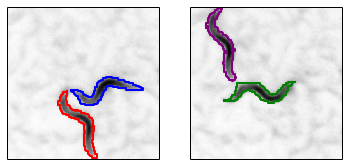

In [23]:
def quick_search(node, graph, experiment):
    p = list(set(graph.predecessors(node)))
    c = list(set(graph.successors(node)))

    print('parents:{p}'.format(p=p))
    print('children:{c}'.format(c=c))
    #print('beginning:end pixel overlap')
    #grab relevant outlines.
    fp0, p0 = cr.grab_outline(p[0], first=False)
    fp1, p1 = cr.grab_outline(p[1], first=False)
    fc0, c0 = cr.grab_outline(c[0], first=True)
    fc1, c1 = cr.grab_outline(c[1], first=True)

    # align outline masks
    outline_list = [o for o in [p0, p1, c0, c1] if o is not None]
    #print(len(outline_list), 'outlines found for', node)
    if not outline_list:
        raise CollisionException
    masks, bbox = points_to_aligned_matrix(outline_list)
    box_width = max([100, 1 + max(masks[0].shape)])
    new_shape = (box_width, box_width)
    #print 'new shape', new_shape
    bbox2 = calc_bbox(bbox, size=new_shape)
    next = 0

    if p0 is not None:
        p_m0 = masks[0]
        next += 1
    else:
        print p0, 'p is none'

    if p1 is not None:
        p_m1 = masks[next]
        next += 1
    else:
        print p1, 'p is none'
        
    if c0 is not None:
        c_m0 = masks[next]
        next += 1
    else:
        print c0, 'c is none'
        
    if c1 is not None:
        c_m1 = masks[next]
    else:
        print c1, 'c is none'

    p_frame = int((fp0 + fp1) / 2)
    c_frame = int((fc0 + fc1) / 2)
    p_time = experiment.frame_times[p_frame]
    c_time = experiment.frame_times[c_frame]

    #print 'parent', p_frame, p_time
    #print 'child', c_frame, c_time

    ################# parents

    fig, ax = plt.subplots(1, 2)
    x, y = zip(*p0)
    x, y = adjust_xy(x, y, bbox2)
    ax[0].plot(x, y, lw=2, color='red')

    x, y = zip(*p1)
    x, y = adjust_xy(x, y, bbox2)
    ax[0].plot(x, y, lw=2, color='blue')

    im = get_cropped_img(experiment, p_time, bbox2)
    ax[0].imshow(im, cmap=plt.cm.Greys_r)
    format_fig(ax[0], bbox2)

    ################## children

    x, y = zip(*c0)
    x, y = adjust_xy(x, y, bbox2)
    ax[1].plot(x, y, lw=2, color='green')

    x, y = zip(*c1)
    x, y = adjust_xy(x, y, bbox2)
    ax[1].plot(x, y, lw=2, color='purple')
    
    im = get_cropped_img(experiment, c_time, bbox2)
    ax[1].imshow(im, cmap=plt.cm.Greys_r)

    format_fig(ax[1], bbox2)
    plt.show()
    
quick_search(node, graph=graph, experiment=experiment)

(800, 1906, 893, 2023)
(787, 1905, 906, 2024)


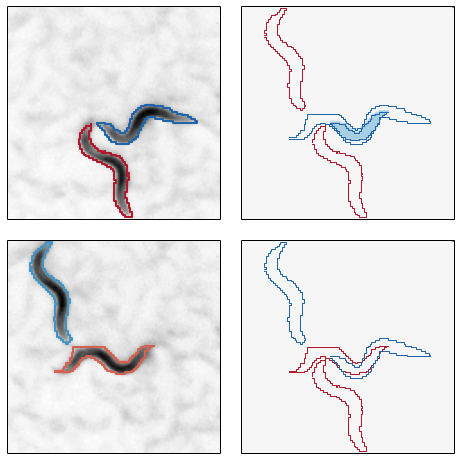

In [25]:
def plot_overlap(node, graph, experiment):
    p = list(set(graph.predecessors(node)))
    c = list(set(graph.successors(node)))
    #print('parents:{p}'.format(p=p))
    #print('children:{c}'.format(c=c))
    #print('beginning:end pixel overlap')
    #grab relevant outlines.
    fp0, p0 = cr.grab_outline(p[0], first=False)
    fp1, p1 = cr.grab_outline(p[1], first=False)
    fc0, c0 = cr.grab_outline(c[0], first=True)
    fc1, c1 = cr.grab_outline(c[1], first=True)

    # align outline masks
    outline_list = [o for o in [p0, p1, c0, c1] if o is not None]
    #print(len(outline_list), 'outlines found for', node)
    if not outline_list:
        raise CollisionException
        
    masks, bbox = points_to_aligned_matrix(outline_list)
    #print 'combined shape', masks[0].shape
    box_width = max([100, 1 + max(masks[0].shape)])
    new_shape = (box_width, box_width)
    #print 'new shape', new_shape
    bbox2 = calc_bbox(bbox, size=new_shape)
    
    next = 0
    if p0 is not None:
        p_m0 = masks[0]
        next += 1
    else:
        print p0, 'p is none'

    if p1 is not None:
        p_m1 = masks[next]
        next += 1
    else:
        print p1, 'p is none'
        
    if c0 is not None:
        c_m0 = masks[next]
        next += 1
    else:
        print c0, 'c is none'
        
    if c1 is not None:
        c_m1 = masks[next]
    else:
        print c1, 'c is none'

    p_frame = int((fp0 + fp1) / 2)
    c_frame = int((fc0 + fc1) / 2)
    p_time = experiment.frame_times[p_frame]
    c_time = experiment.frame_times[c_frame]

    #print 'parent', p_frame, p_time
    #print 'child', c_frame, c_time


    
    #print len(outline_list), 'number of outlines found'
    print bbox
    print bbox2
    def make_merge(pair1, pair2):
        p_m0, c_m1 = pair1
        p_m1, c_m0 = pair2
        merge_1a = rescale_mask((p_m0 & c_m1), bbox, bbox2).T
        merge_1b = rescale_mask((p_m1 & c_m0), bbox, bbox2).T
        #ax.contour(merge_1a, levels=[0.99], linewidths=1.2, colors=['blue'])
        #ax.contour(merge_1b, levels=[0.001], linewidths=1.2, colors=['red'])
        #im = get_cropped_img(experiment, c_time, bbox2)
        #ax.imshow(im, cmap=plt.cm.Greys_r)
        mix = -0.5 * np.array(merge_1a, dtype=float) + 0.5 * np.array(merge_1b, dtype=float) + 0.5
        mix[0,0] = -1.0
        mix[-1, -1] = 2.0
        return mix

    
    x, y = zip(*p0)
    px1, py1 = adjust_xy(x, y, bbox2)
    x, y = zip(*p1)
    px2, py2 = adjust_xy(x, y, bbox2)
    x, y = zip(*c0)
    cx1, cy1 = adjust_xy(x, y, bbox2)
    x, y = zip(*c1)
    cx2, cy2 = adjust_xy(x, y, bbox2)
    
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(2, 2)
    gs.update(wspace=0.1, hspace=0.1)
    ax0 = plt.subplot(gs[0,0])
    ax1 = plt.subplot(gs[1,0])
    ax2 = plt.subplot(gs[0,1])
    ax3 = plt.subplot(gs[1,1])

    ########## options
    
    # line weights
    p_lw = c_lw = 2
    merge_lw = 1
    
    # merge colors
    cmap = plt.cm.Spectral
    cmap = plt.cm.RdBu
    ################# parents

    #print 'parents'
    #fig, ax = plt.subplots()
    ax0.plot(px1, py1, lw=p_lw, color=cmap(0.1))
    ax0.plot(px2, py2, lw=p_lw, color=cmap(0.9))

    im = get_cropped_img(experiment, p_time, bbox2)
    ax0.imshow(im, cmap=plt.cm.Greys_r)
    format_fig(ax0, bbox2)
    #plt.show()

    ################## children

    #print 'children'
    #fig, ax = plt.subplots()
    ax = ax1

    ax.plot(cx1, cy1, lw=c_lw, color=cmap(0.2))
    ax.plot(cx2, cy2, lw=c_lw, color=cmap(0.8))

    im = get_cropped_img(experiment, c_time, bbox2)
    ax.imshow(im, cmap=plt.cm.Greys_r)
    format_fig(ax, bbox2)
    #plt.show()

    ################## merge1
    #print 'top'
    #print p[0], '->', c[1]
    #print p[1], '->', c[0]   
    #f, ax = plt.subplots()
    ax = ax2
    merge = make_merge(pair1=[p_m0, c_m1], pair2=[p_m1, c_m0])
    ax.imshow(merge, cmap=cmap, interpolation=None)
    ax.plot(px1, py1, lw=1, color=cmap(0.1))
    ax.plot(cx2, cy2, lw=1, color=cmap(0.1))

    ax.plot(px2, py2, lw=1, color=cmap(0.9))
    ax.plot(cx1, cy1, lw=1, color=cmap(0.9))
    
    ax.set_aspect('equal')
    format_fig(ax, bbox2)
    #plt.show()
    
    ################## merge2
    #print 'bottom'
    #print p[0], '->', c[0]
    #print p[1], '->', c[1]   
    #f, ax = plt.subplots()
    ax = ax3
    merge = make_merge(pair1=[p_m0, c_m0], pair2=[p_m1, c_m1])
    ax.imshow(merge, cmap=cmap, interpolation=None)
    #print mix
    ax.plot(px1, py1, lw=1, color=cmap(0.1))
    ax.plot(cx1, cy1, lw=1, color=cmap(0.1))
    
    ax.plot(px2, py2, lw=1, color=cmap(0.9))
    ax.plot(cx2, cy2, lw=1, color=cmap(0.9))
    ax.set_aspect('equal')
    format_fig(ax, bbox2)
    #plt.show()
    return fig

# def rescale_mask(m, mask_bbox, new_bbox):
#     xmin, ymin, xmax, ymax = new_bbox
#     xmin0, ymin0, xmax0, ymax0 = mask_bbox
#     dxmin = xmin0 - xmin
#     dymin = ymin0 - ymin
#     dxmax = xmax0 - xmax
#     dymax = ymax0 - ymax
#     mx, my = m.shape
#     print 'bbox', new_bbox
#     print 'mask', mask_bbox
#     print 'd', dxmin, dymin #, dxmax, dymax
#     print 'x', dxmin, 'to',  dxmin+mx, '=', mx
#     print 'y', dymin, 'to', dymin+my, '=', my

#     print m.shape
#     new = np.zeros(shape=(xmax - xmin, ymax -  ymin))
#     print new.shape
    
#     #print new[dxmin:dxmin+mx, dymin:dymin+my].shape
#     new[dxmin:dxmin+mx, dymin:dymin+my] = m
#     #new[0:mx, 0:my] = m

#     return new 

# node = 55656
node = 298
fig = plot_overlap(node = node, graph=graph, experiment=experiment)
#savename = 
#print savename
plt.savefig('overlap-{n}.png'.format(n=node))
plt.show()

51
204 to 208

1134 doubles left
4436
parents:[5, 1535]
children:[4437, 4438]


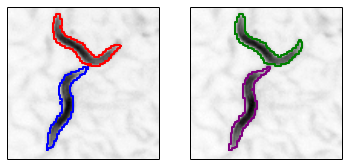

35158
parents:[35146, 35147]
children:[35277, 35278]


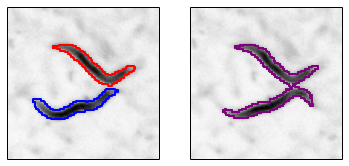

343
parents:[309, 63]
children:[419, 420]


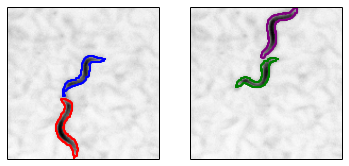

4442
parents:[4437, 4438]
children:[4499, 4500]


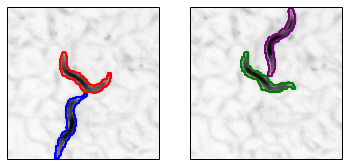

In [42]:
N = 4
#step = 40
step += 1
print step
print step*N, 'to', step * N + N
print
doubles = list(set(doubles))
print len(doubles) - step - N, 'doubles left'
r = np.array(doubles)[(step*N): step * N + N]
for node in r:
    try:
        print node
        quick_search(node, experiment=experiment, graph=graph)
        plt.show()
    except Exception as e:
        print node, 'failed', e

4442
(988, 1303, 1037, 1431)
(947, 1302, 1077, 1432)


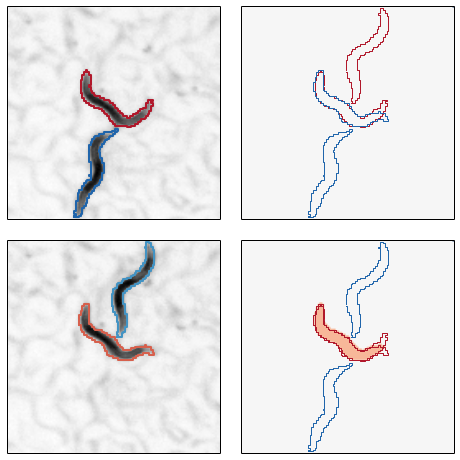

In [43]:
weirdness = [16637, 33030]
nodes_to_checkout = [12514, 69861, 298, 33087, 14581, 4442]

i = -1
node = nodes_to_checkout[i]
#node = weirdness[i]
print node
plot_overlap(node = node, graph=graph, experiment=experiment)
plt.savefig('overlap-{n}.png'.format(n=node))
plt.show()

parents:[22138, 22139]
children:[22914, 22915]
parent 53153 2066.012
child 53607 2083.745
parents
children
merge 1
22138 -> 22915
22139 -> 22914
merge 2
22138 -> 22914
22139 -> 22915


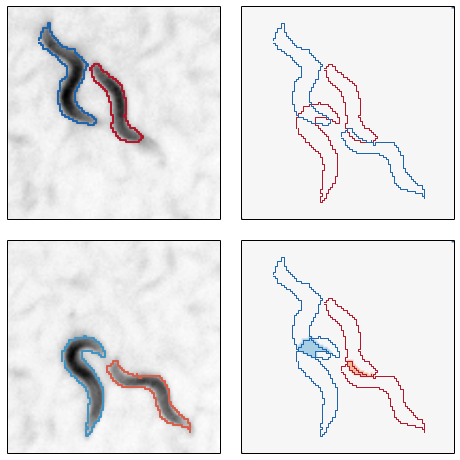

In [134]:
node = 22221
plot_overlap(node = node, graph=graph, experiment=experiment)
plt.savefig('overlap-{n}.png'.format(n=node))
plt.show()

parents:[4504, 4505]
children:[4528, 4529]
parent 8651 338.656
child 8758 342.725
parents
children
merge 1
4504 -> 4529
4505 -> 4528
merge 2
4504 -> 4528
4505 -> 4529


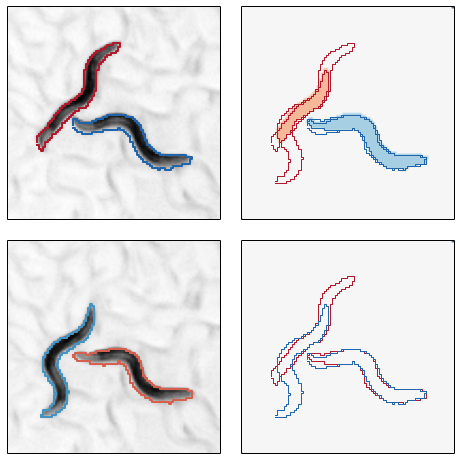

In [137]:
node = 4509
plot_overlap(node = node, graph=graph, experiment=experiment)
plt.savefig('overlap-{n}.png'.format(n=node))